# Quadratic RF Spoiling bSSFP #

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit

import pandas as pd
import openpyxl

In [2]:
# FUNCTIONS
#RF pulse excitation matrix
def RF_pulse(alpha, phi):
    #The RF pulse tip the spin "alpha" degree from z axis
    #and a phase shift of "phi" degree clockwise from x axis
    
    #convert in to radians 
    a = math.radians(alpha)
    p = math.radians(phi)
    #each term of the matrix
    r11 = math.cos(a)*math.sin(p)**2 + math.cos(p)**2
    r12 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r13 = - math.sin(a)*math.sin(p)
    r21 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r22 = math.cos(a)*math.cos(p)**2 + math.sin(p)**2
    r23 = math.sin(a)*math.cos(p)
    r31 = math.sin(a)*math.sin(p)
    r32 = - math.sin(a)*math.cos(p)
    r33 = math.cos(a)
    R = np.asarray([[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]], dtype = float)
    
    return R

#T1 recovery, T2 decay terms effect for time t
def Relaxation(t, T1, T2):
    e2 = np.exp(-t/T2)
    e1 = np.exp(-t/T1)
    E = np.asarray([[e2 , 0, 0],[0, e2, 0],[0, 0, e1]], dtype = float)
    
    return E

#Precession term effect on off-resonance (f_off Hz) spin at time t
def Precession(f_off, t):
    #free-precession angle beta
    b = f_off*t*2*math.pi
    #rad
    #b = math.radians(beta)
    P = np.asarray([[math.cos(b), math.sin(b), 0],[-math.sin(b), math.cos(b), 0],[0, 0, 1]], dtype = float)
    
    return P

#Calculate the phase shift for current TR (quadratic spoiling)
def QuadraticPhase(N, n):
    n = n%N
    phi_quad = 360/N
    phase = phi_quad*n*n/2
 
    #in degree
    return phase


<p>Parameters T1, T2, TR, TE, tip angle, period, initial magnetisation. <p/>
<p>phase $\phi_n =\frac{n^2 \times \phi_{quad}}{2} $ <p/>

# quadatic RF spoiling bSSFP data simulation function #


In [3]:

def bSSFPSimulation(T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, dataAcquire, TRnum):
    #store value
    off_resonance_f = np.asarray([], dtype = int)
    M_complex_steady_all = np.asarray(np.zeros((dataAcquire,1)), dtype = float)


    #Find steady state value for different off-resonance 
    #f_off = 200 is next period, so here we only use -200~199
    for f_off in range(-off_res_max,off_res_max,1):
        M_pre = M0 #initial pre pulse magnetisation 

        #store complex transverse magnitude at different TRs
        M_complex_steady = np.asarray([], dtype = float)
        #store all complex transverse magnitude 
        M_complex = np.asarray([], dtype = float)
        phase_shift = 0
        Period_num = 0



        #repeat TRnum times for each off-resonance frequency
        for k in range(1,TRnum):
            #Calculate phase shift (degree) for this TR
            phase_shift = QuadraticPhase(Period, Period_num)
            #Tip
            M_post = RF_pulse(tip_angle,phase_shift) @ M_pre

            #Consider T1 recovery, T2 decay and precession
            #@ time TE 
            P_TE = Precession(f_off,TE) #precession matrix at t = TE
            E_TE = Relaxation(TE, T1, T2) #Relaxation matrix at t = TE

            M_TE = P_TE @ E_TE @ M_post + (np.identity(3) - E_TE) @ M0 #magnetisation at TE
            

            #@ time TR 
            P_TR = Precession(f_off,TR) #precession matrix at t = TR
            E_TR = Relaxation(TR, T1, T2) #Relaxation matrix at t = TR
            M_TR = P_TR @ E_TR @ M_post + (np.identity(3) - E_TR) @ M0 #magnetisation at TR
            M_pre = M_TR

            #store the transverse magnetisation in complex form, Mx+iMy
            M_complex = np.append(M_complex, complex(M_TE[0],M_TE[1]))

            Period_num = Period_num + 1     
        #END
        #take the final steady signal, store the transverse steady state signal for different off-resonance frequency
        for state in range (1,dataAcquire+1):
            M_complex_steady = np.append(M_complex_steady, M_complex[-state])
        off_resonance_f = np.append(off_resonance_f, f_off)
        M_complex_steady = np.reshape(M_complex_steady,(dataAcquire,1))
        M_complex_steady_all = np.append(M_complex_steady_all, M_complex_steady, axis = 1)
        
    #END
    M_complex_steady_all = np.delete(M_complex_steady_all,0,1)
    
    return M_complex_steady_all, off_resonance_f

#return 
#transverse steady state magnitude at different off-resonance frequency (column) and when acquire at different TR (row)
#corresponding off-resonance frequency


In [4]:
#Off-resonance profile magnitude --> F-state magnitude 
def Fstate(M_transverse):
    F_Magnitude = np.fft.fft(M_transverse)
    F_Magnitude = np.absolute(F_Magnitude)
    F_Magnitude = np.fft.fftshift(F_Magnitude)

    F_state = np.fft.fftfreq(M_transverse.shape[-1], d = 1.0)
    F_state = np.fft.fftshift(F_state)*M_transverse.shape[-1]
    
    return F_Magnitude, F_state


#plot off resonance profile and F-state profile for multiple data acquisition 
#dataAcquire: number of profile
#off_resonance_f (n,) || M_transverse (dataAcquire, n)

def Offres_Fstate_plot(off_resonance_f, M_transverse, dataAcquire, Period, Fmin, Fmax):
    
    #Fourier transform of the off-resonance profile --> contribution from each F-state
    S_F = np.fft.fft(M_transverse)
    S_F = np.absolute(S_F)
    S_F = np.fft.fftshift(S_F)

    F_state = np.fft.fftfreq(M_transverse.shape[-1], d = 1.0)
    F_state = np.fft.fftshift(F_state)*M_transverse.shape[-1]
    

    fig, axs  = plt.subplots(dataAcquire,2,figsize=(15, 5))
    if (dataAcquire == 1):
        axs[0].set_title("off-resonance profile")
        axs[1].set_title("Fstate of " + str(Period)+ " period")

        axs[0].plot(off_resonance_f, np.absolute(M_transverse[0,:]))
        axs[0].set_xlabel("off resonance frequency (Hz)")
        axs[0].set_ylabel("$|M_{xy}|$")

        axs[1].bar(F_state, S_F[0,:])
        axs[1].set_xlim([Fmin,Fmax])
        axs[1].set_xlabel("F state")
        axs[1].set_ylabel("$S_F$")
    else:    
        axs[0,0].set_title("off-resonance profile")
        axs[0,1].set_title("Fstate of " + str(Period)+ " period")
        for i in range (0,dataAcquire):
            axs[i,0].plot(off_resonance_f, np.absolute(M_transverse[i,:]))
            axs[i,0].set_xlabel("off resonance frequency (Hz)")
            axs[i,0].set_ylabel("$|M_{xy}|$")



            axs[i,1].bar(F_state, S_F[i,:])
            axs[i,1].set_xlim([Fmin,Fmax])
            axs[i,1].set_xlabel("F state")
            axs[i,1].set_ylabel("$S_F$")
    return fig, axs


#Add field inhomogeneous to model T2* effect (for F_number F-states, F_number = 6 --> 0,1,2...5 F-states
def fieldInhomogeneous(F_state_magnitude, F_state, TR, TE, T2prime, F_number):
    #select number of F-state needed
    F_Magnitude = np.asarray([], dtype = float)
    F = np.asarray([], dtype = float)
    F_state = np.round(F_state).astype(int) #round F-state all to integer 

    for i in range (0,F_number):
        F_index = np.where(F_state == float(-1-2*i))

        F = np.append(F, i)
        F_Magnitude = np.append(F_Magnitude, F_state_magnitude[F_index])
        # print('F-state:'+ str(i) +' S_F:'+ str(S_F[F_index]))
    #End

    ## time = TE+F*TR
    time = TE*np.ones(np.shape(F))+ F *TR
    F_Magnitude = F_Magnitude *np.exp(-time/T2prime)
    return F_Magnitude, time


# Simulation

In [5]:
# the parameters used in this simulation 
#time unit --- second
proton_density = 1.0
T1 = 900e-3
T2 = 44e-3
TR = 2.5e-3 
TE = TR/2
# tip angle alpha 10, 30, 90 degree
tip_angle = 10
#phase cycling
Period = 8
#initial magnetisation 
M0 = np.asarray([[0],[0],[1]],dtype = float)

off_res_max = 400
#Rep_num = off_res_max*2/(1/TR)
dataAcquire = 1
TRnum = 500

#T2* range 13 ms to 53 ms
T2s_max = 53
T2s_min = 13
T2p = np.asarray([], dtype = float)

for i in range (T2s_min, T2s_max):
    if ((i != (T2*1000)) and (i != 0)):
        T2p = np.append(T2p, 1/((1000/i)-1/T2))
#number of simulation run
testnumber = 1000


In [6]:
#Generate bSSFP off-resonance profile using Bloch simulation 
M_transverse, off_resonance_f = bSSFPSimulation(T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, dataAcquire, TRnum)
  

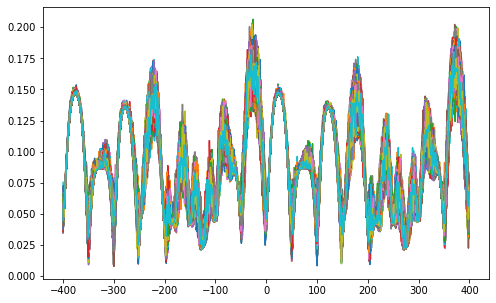

In [7]:
#
#Define arrays for store information ---------------------------
index = np.asarray([], dtype = str)
for i in range (1,testnumber+1):
    index = np.append(index, str(i))
    
#200*(T2'number) matrix storing T2* ground truth and measured --> used to calculate error later 
T2s_gt_all = np.asarray(np.zeros((1,np.shape(T2p)[0])), dtype = float)
T2s_m_all = np.asarray(np.zeros((1,np.shape(T2p)[0])), dtype = float)
#200*2 matrix storing mean error and sd
ErrorMeanSd = np.asarray(np.zeros((1,2)), dtype = float)

figNoise, ax = plt.subplots(figsize = (8,5))

  
#Start run simulation-----------------------------------------------
for test in range (1,testnumber+1):
    #Add Noise
    M_transverse_noise = M_transverse + np.random.normal(0,0.01,np.shape(M_transverse)[-1])

    #Fourier transform of the off-resonance profile --> contribution from each F-state
    F_Magnitude, F_state = Fstate(M_transverse_noise)
    # plt.figure(1)
    # plt.plot(off_resonance_f, np.abs(M_transverse_noise[0,:]))
    ax.plot(off_resonance_f, np.abs(M_transverse_noise[0,:]))
    

    #Add field inhomogeneous T2'
    #Recording ground truth T2* and calculated T2*
    T2Star_GT = np.asarray([], dtype = float)
    T2Star_measured = np.asarray([], dtype = float)
    F_Magnitude = F_Magnitude[0,:]
    

    for T2_inhom in T2p:
        #-----------------Calculate Ground Truth T2*---------------------------------------------------
        T2Star_GT = np.append(T2Star_GT, 1/((1/T2)+(1/T2_inhom)))

        #-----------------Calculate the T2* from simulation data (measured T2*)------------------------
        #recorded 6 F-states (due to the use of Bloch simulation, these F-states magnitude can only fit a T2 decay curve
        #Add field inhomogeneous (T2* decay)
        if (Period <=6):
            F_t2star, time = fieldInhomogeneous(F_Magnitude, F_state, TR, TE, T2_inhom, Period)
        else:
            F_t2star, time = fieldInhomogeneous(F_Magnitude, F_state, TR, TE, T2_inhom, 6)

        #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
        #exponential curve fitting to find T2* value
        def func(t, A, R2Star):
            return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
        popt, pcov = curve_fit(func, time, F_t2star)
        T2Star_measured = np.append(T2Star_measured, 1/popt[1])
    #For End
    
    #calculate error
    T2s_gt_all = np.append(T2s_gt_all, [T2Star_GT], axis = 0)
    T2s_m_all = np.append(T2s_m_all, [T2Star_measured], axis = 0)
    Error_test = np.square(T2Star_GT-T2Star_measured)
    ErrorMeanSd = np.append(ErrorMeanSd, [(np.mean(Error_test), np.std(Error_test))], axis = 0)
#For End
ErrorMeanSd = np.delete(ErrorMeanSd, 0, 0)
T2s_gt_all = np.delete(T2s_gt_all, 0, 0)
T2s_m_all = np.delete(T2s_m_all, 0, 0)
Error = T2s_m_all-T2s_gt_all

    

<Figure size 432x288 with 0 Axes>

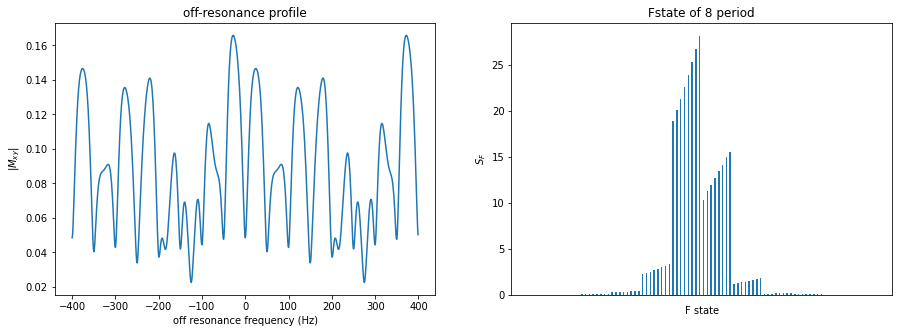

In [8]:
#No Noise off-resonance profile and F-state profile 
plt.figure(1)
fig, axs = Offres_Fstate_plot(off_resonance_f, M_transverse, dataAcquire, Period, -100, 100)
axs[1].set(xticklabels=[])
axs[1].tick_params(bottom=False) 
#fig.savefig("./Figure/noise/4Period_NoNoise.jpg")

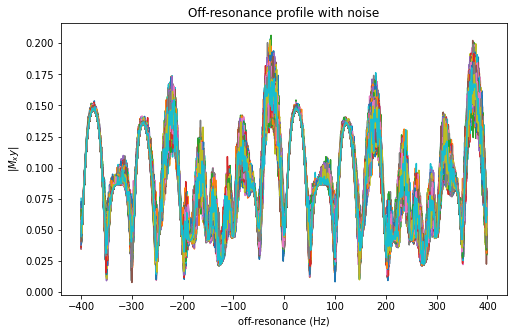

In [9]:
#Noise off-resonance profile and F-state profile 
ax.set(xlabel="off-resonance (Hz)")
ax.set(ylabel="$|M_xy|$")
ax.set(title="Off-resonance profile with noise")
figNoise
#figNoise.savefig("./Figure/noise/4Period_1000NoiseOffResProfile.jpg")

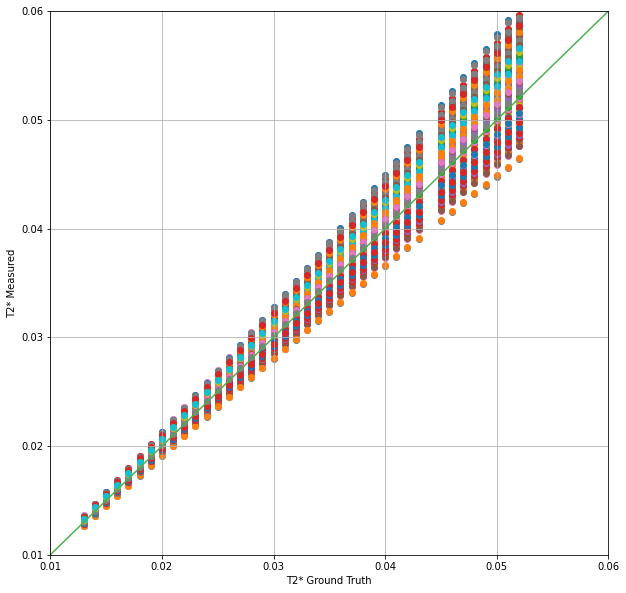

In [10]:
plt.figure(figsize=(10,10))
plt.xlabel("T2* Ground Truth")
plt.ylabel("T2* Measured")
x1 = np.array([-2,5])
y1 = np.array([-2,5])
plt.plot(x1,y1,c = '#4CAF50')
plt.xlim(10e-3, 60e-3)
plt.ylim(10e-3, 60e-3)
plt.grid()
for i in range (0,testnumber):
    plt.scatter(T2s_gt_all[i,:], T2s_m_all[i,:])
    
#plt.savefig("./Figure/noise/4Period_1000WithNoise.jpg") 

In [134]:

#store data in excel
error = pd.DataFrame(Error, index )
groundtruth = pd.DataFrame(T2s_gt_all, index )
measured = pd.DataFrame(T2s_m_all, index )
error_mean_sd = pd.DataFrame(ErrorMeanSd,
                  index, columns=['Mean Error', 'Standard Deviation'])

with pd.ExcelWriter('SimulatedData4Period1000Noise.xlsx') as writer:
    error.to_excel(writer, sheet_name='Error')
    error_mean_sd.to_excel(writer, sheet_name='Error_mean_sd')
    groundtruth.to_excel(writer, sheet_name='Ground_Truth_T2_Star')
    measured.to_excel(writer, sheet_name='Measured_Truth_T2_Star')
   

0.0
22.5
90.0
202.5
360.0
562.5
810.0
1102.5


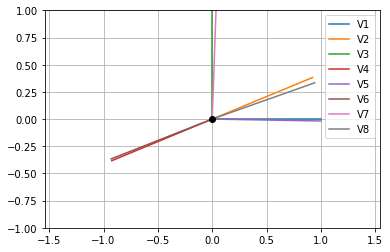

In [11]:
#Visualise the RF quadratic spoiling angle
Period = 8
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
V = np.asarray([[0,0]], dtype = float)
for i in range (0,Period):
    p = QuadraticPhase(Period,i)
    phaseshift_rad = np.radians(p-(p//360))
    print(p)
    #line_1 = plt.Line2D([0,math.cos(phaseshift_rad)], [0,math.sin(phaseshift_rad)], linewidth=1, linestyle = "-", label = i)
    #ax.add_line(line_1)

    V = np.append(V,[[math.cos(phaseshift_rad),math.sin(phaseshift_rad)]], axis =0)
    

V = np.delete(V, 0,0)
# origin = np.array(np.zeros((2,Period))) # origin point
# plt.quiver(*origin, V[:,0], V[:,1], scale=5)
# plt.show()

# ax.set(xlim=[-1,1])
# ax.set(ylim=[-1,1])
#print(V)

rows,cols =V.T.shape

#Get absolute maxes for axis ranges to center origin
#This is optional
maxes = 1.1*np.amax(abs(V), axis = 0)

for i,l in enumerate(range(0,cols)):
    xs = [0,V[i,0]]
    ys = [0,V[i,1]]
    plt.plot(xs,ys)

plt.plot(0,0,'ok') #<-- plot a black point at the origin
plt.axis('equal')  #<-- set the axes to the same scale
plt.xlim([-1,1]) #<-- set the x axis limits
plt.ylim([-1,1]) #<-- set the y axis limits
plt.legend(['V'+str(i+1) for i in range(cols)]) #<-- give a legend
plt.grid(True) #<-- plot grid lines
plt.show()

## 

# Measured & Ground Truth T2* calculation #
<p>Calculate T2* ground truth and T2* measured stored in "T2Star_measured" and "T2Star_GT" </p>
<p><b>The Parkinson's Disease T2, T2* coefficient: </b></p>
<p> T1 = 878ms, T2 = 55ms, T2* = 53ms </p>
<p><b>The Healthy Controls T2, T2* coefficient: </b></p>
<p> T1 = 893ms, T2 = 33ms, T2* = 13ms </p>
<p>Using the equation $\frac{1}{T2'} = \frac{1}{T2*}-\frac{1}{T2}$</p>
<p>take average T2 = $\frac{55+33}{2} = 44 ms$ </p>
<p>$\frac{1}{T2'} = \frac{1}{T2*}-\frac{1}{44 ms}$</p>
<p>T2* in range 13 ms to 53 ms when T2' is greater than 0.0185, or smaller than -0.2591 </p>
<p>T2' in range 15 ms to 400 ms </p>

In [11]:
T2Star_GT = np.asarray([], dtype = float)
T2Star_measured = np.asarray([], dtype = float)
S_F_1 = S_F[0,:]

for T2_inhom in range (15, 400):
    T2_inhom = T2_inhom*1e-3
    if ((T2_inhom != 0) and (T2_inhom != -T2)):
        
        #-----------------Calculate Ground Truth T2*---------------------------------------------------
        T2Star_GT = np.append(T2Star_GT, 1/((1/T2)+(1/T2_inhom)))

        #-----------------Calculate the T2* from simulation data (measured T2*)------------------------
        #recorded 6 F-states (due to the use of Bloch simulation, these F-states magnitude can only fit a T2 decay curve)
        F_t2 = np.asarray([], dtype = float)
        F_t2_statenum = np.asarray([], dtype = float)
        F_state = np.round(F_state).astype(int) #round F-state all to integer 

        for i in range (0,7):
            F_index = np.where(F_state == float(-1-2*i))

            F_t2_statenum = np.append(F_t2_statenum, i)
            F_t2 = np.append(F_t2, S_F_1[F_index])
            # print('F-state:'+ str(i) +' S_F:'+ str(S_F[F_index]))

        #transfer F-states (T2 related) to F-states (T2* related)
        F_t2star = np.asarray([], dtype = float)
        time = np.asarray([], dtype = float)
        ## time = TE+F*TR
        time = TE*np.ones(np.shape(F_t2_statenum))+ F_t2_statenum *TR
        F_t2star = F_t2 *np.exp(-time/T2_inhom)

        #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
        #exponential curve fitting to find T2* value
        def func(t, A, R2Star):
            return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
        popt, pcov = curve_fit(func, time, F_t2star)
        T2Star_measured = np.append(T2Star_measured, 1/popt[1])


    #--------------Plots----------------------------------------------------------------------------
#     plt.figure(1)
#     plt.title("F-state magnitude against F-state (T2 decay curve due to Bloch simulation)")
#     plt.bar(F_t2_statenum, F_t2)
#     plt.xlabel("F state")
#     plt.ylabel("$S_F$")

#     plt.figure(2)
#     plt.title("F-state magnitude against time (T2* decay curve)")
#     plt.scatter(time, F_t2star, label = '7 F-state data points')
#     plt.plot(time, func(time, *popt),'r-', label='fit: A=%5.3f, R2*=%5.3f' % tuple(popt))
#     plt.xlabel("time")
#     plt.ylabel("$F-state Magnitude$")
#     plt.legend()

    #print('\nT2* Ground Truth: '+str(T2Star_GT) +'\nT2* Measured: '+ str(T2Star_measured))

# Plot measured T2* against ground truth T2*

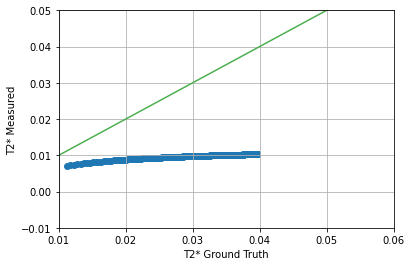

In [12]:
plt.figure
plt.scatter(T2Star_GT, T2Star_measured)
plt.xlabel("T2* Ground Truth")
plt.ylabel("T2* Measured")
x1 = np.array([-2,5])
y1 = np.array([-2,5])
plt.plot(x1,y1,c = '#4CAF50')
plt.xlim(10e-3, 60e-3)
plt.ylim(-10e-3, 50e-3)
plt.grid()
#plt.savefig(".\Figure\T2Starvalue_measuredTotruth_" + str(Period)+"_period.jpg")

# Show fitting method 


T2* Ground Truth: 0.012774193548387096
T2* Measured: 0.012847296079296784


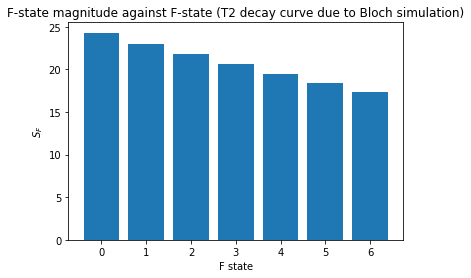

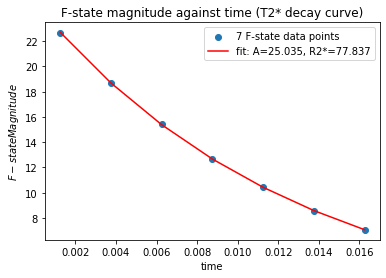

In [153]:
T2_inhom = 18e-3

#-----------------Calculate Ground Truth T2*---------------------------------------------------
T2Star_GT = 1/((1/T2)+(1/T2_inhom))

#-----------------Calculate the T2* from simulation data (measured T2*)------------------------
#recorded 6 F-states (due to the use of Bloch simulation, these F-states magnitude can only fit a T2 decay curve)
F_t2 = np.asarray([], dtype = float)
F_t2_statenum = np.asarray([], dtype = float)
F_state = np.round(F_state).astype(int) #round F-state all to integer 

for i in range (0,7):
    F_index = np.where(F_state == float(-1-2*i))

    F_t2_statenum = np.append(F_t2_statenum, i)
    F_t2 = np.append(F_t2, S_F[F_index])
    # print('F-state:'+ str(i) +' S_F:'+ str(S_F[F_index]))

#transfer F-states (T2 related) to F-states (T2* related)
F_t2star = np.asarray([], dtype = float)
time = np.asarray([], dtype = float)
## time = TE+F*TR
time = TE*np.ones(np.shape(F_t2_statenum))+ F_t2_statenum *TR
F_t2star = F_t2 *np.exp(-time/T2_inhom)

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
#exponential curve fitting to find T2* value
def func(t, A, R2Star):
    return A * np.exp(-R2Star * t)
#fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
popt, pcov = curve_fit(func, time, F_t2star)
T2Star_measured = 1/popt[1]


#--------------Plots----------------------------------------------------------------------------
plt.figure(1)
plt.title("F-state magnitude against F-state (T2 decay curve due to Bloch simulation)")
plt.bar(F_t2_statenum, F_t2)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.savefig(".\Figure\FstateOf" + str(Period)+"_period.jpg")

plt.figure(2)
plt.title("F-state magnitude against time (T2* decay curve)")
plt.scatter(time, F_t2star, label = '7 F-state data points')
plt.plot(time, func(time, *popt),'r-', label='fit: A=%5.3f, R2*=%5.3f' % tuple(popt))
plt.xlabel("time")
plt.ylabel("$F-state Magnitude$")
plt.legend()
plt.savefig(".\Figure\T2Starfit" + str(Period)+"_period.jpg")
print('\nT2* Ground Truth: '+str(T2Star_GT) +'\nT2* Measured: '+ str(T2Star_measured))

In [146]:
np.radians(925.7142857142857)

16.156762218461793

In [168]:
405-360

45

In [167]:
for i in range (0,24):
    p = QuadraticPhase(4,i)
    print(p)

0.0
45.0
180.0
405.0
0.0
45.0
180.0
405.0
0.0
45.0
180.0
405.0
0.0
45.0
180.0
405.0
0.0
45.0
180.0
405.0
0.0
45.0
180.0
405.0


Text(0, 0.5, '$S_F$')

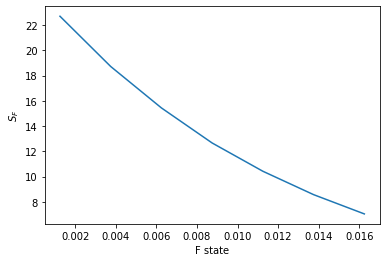

In [61]:
plt.figure
plt.plot(time, F_t2star)
plt.xlabel("F state")
plt.ylabel("$S_F$")

Text(0.5, 1.0, 'Off-resonance Profile tip angle:10')

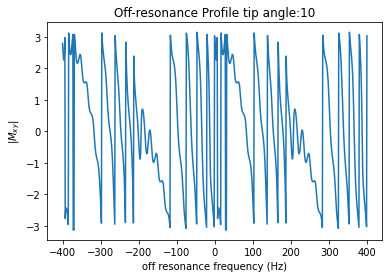

In [ ]:
plt.figure(4)
plt.plot(off_resonance_f, np.angle(M_complex_steady))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title("Off-resonance Profile tip angle:" + str(a))